Import Games of Elo ~1100

In [4]:
import pandas as pd 
import torch 
from torch.utils.data import Dataset
import dask.dataframe as dd 
import numpy as np
import torch.nn as nn
import math
import chess
import random
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
grouped_df = pd.read_csv("haha_longer-oct.csv")
print(grouped_df)

          game_id                                              moves  \
0        0Gws7Yna  e2e4 d7d5 e4d5 d8d5 b1c3 d5d8 d2d4 e7e6 g1f3 g...   
1        0JraozGk  e2e4 e7e6 g1f3 d7d5 e4d5 e6d5 b1c3 g8f6 h2h3 f...   
2        0b0GOLhX  e2e4 e7e5 d2d4 e5d4 d1d4 b8c6 d4e3 g8f6 b1c3 f...   
3        0cFU8tom  d2d4 d7d5 c2c4 g8f6 b1c3 d5c4 g1f3 f6d5 d1a4 d...   
4        0t0cIxvG  e2e4 g8f6 b1c3 e7e5 g1f3 b8c6 d2d4 f8b4 d4e5 f...   
...           ...                                                ...   
1765802  yVoCIrMn  g2g3 e7e5 f1g2 g8f6 d2d3 f8b4 c2c3 b4c5 c1g5 e...   
1765803  ye0i70ef  e2e4 e7e5 f2f4 e5f4 g1f3 f8d6 d2d4 f7f6 f1c4 a...   
1765804  yqbJ4tdl  e2e4 e7e5 d1f3 g8f6 c2c3 b8c6 h2h3 d7d6 a2a3 f...   
1765805  yxxxCoPD  e2e4 c7c5 g1f3 d7d6 d2d3 g8f6 h2h3 e7e5 b1c3 b...   
1765806  z6ZuZakH  e2e4 e7e5 g1f3 b8c6 d2d4 e5d4 c2c3 g8f6 e4e5 f...   

         white_elo  black_elo  white_active  \
0             1529       1504          True   
1             1519       1506          Tr

In [6]:
trainX, trainY, vocab = df_to_data(grouped_df, sampling_rate=0.75)

KeyboardInterrupt: 

In [ ]:
print(len(vocab.id_to_move.keys()))
print(torch.tensor(trainX[0]).shape)
print(trainX[0])

57
torch.Size([12, 8, 8])
[[[0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], [[0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

Functions for training

In [ ]:
def train_cnn(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    swa_model = AveragedModel(model)
    swa_start = 1
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, labels in train_loader:
            count += 1
            sequences, labels = sequences.to(device), labels.to(device)
            # Forward Pass
            output = model(sequences)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        if epoch >= swa_start:
            swa_model.update_parameters(model)
        torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for sequences, labels in val_loader:
                    sequences, labels = sequences.to(device), labels.to(device)
                    outputs = model(sequences)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values, swa_model

Now let's train

In [ ]:
dataset = ChessDataset(trainX, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)

1720499


## Experiment 1 (Random CNN Architecture)
```
class ChessCNN(nn.Module):
    def __init__(self, d_out):
        super(ChessCNN, self).__init__()
        # Assuming each channel represents a different piece type (e.g., 12 channels for 6 types each for black and white)
        self.conv1 = nn.Conv2d(6, 12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Assuming an 8x8 chess board
        self.fc2 = nn.Linear(128, d_out)

    def forward(self, x):
        # Apply convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
```

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1089684
1266062


Epoch 1, Batch: 1000| Training Loss: 5.323006882429123
Epoch 1, Batch: 2000| Training Loss: 5.083341435432434
Epoch 1, Batch: 3000| Training Loss: 4.925651387294134
Epoch 1, Batch: 4000| Training Loss: 4.821523460566998
Epoch 1, Batch: 5000| Training Loss: 4.74446098356247
Epoch 1, Batch: 6000| Training Loss: 4.6811313844521845
Epoch 1, Batch: 7000| Training Loss: 4.62994405242375
Epoch 1, Batch: 8000| Training Loss: 4.586579279899597
Epoch 1, Batch: 9000| Training Loss: 4.5478856844372215
Epoch 1, Batch: 10000| Training Loss: 4.513553984165192
Epoch 1, Batch: 11000| Training Loss: 4.484656995209781
Epoch 1, Batch: 12000| Training Loss: 4.458004726966222
Epoch 1, Batch: 13000| Training Loss: 4.435404286439602
Epoch 1, Batch: 14000| Training Loss: 4.414967601776123
Epoch 1, Batch: 15000| Training Loss: 4.394928336207072
Epoch 1, Batch: 16000| Training Loss: 4.376927912965417
Epoch 1, Batch: 17000| Training Loss: 4.360330949278439
Epoch 1, Training Loss: 4.3598570778161685, Validation Er

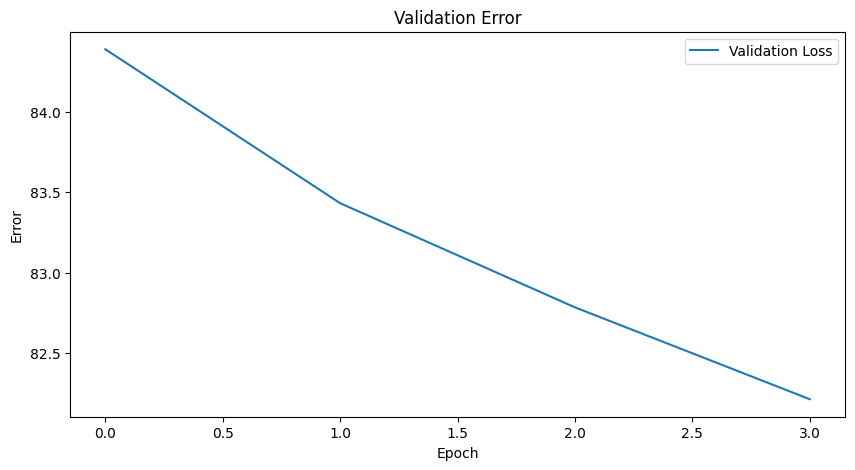

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 2 (Random CNN + Batch Norm)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
# We modified it to have batch norm
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1634273
1266214


Epoch 1, Batch: 1000| Training Loss: 5.300418655395508
Epoch 1, Batch: 2000| Training Loss: 5.094209085345268
Epoch 1, Batch: 3000| Training Loss: 4.974344409783681
Epoch 1, Batch: 4000| Training Loss: 4.8837818021178245
Epoch 1, Batch: 5000| Training Loss: 4.809753782558441
Epoch 1, Batch: 6000| Training Loss: 4.752720592538516
Epoch 1, Batch: 7000| Training Loss: 4.707095052650996
Epoch 1, Batch: 8000| Training Loss: 4.665349202662706
Epoch 1, Batch: 9000| Training Loss: 4.631721228255166
Epoch 1, Batch: 10000| Training Loss: 4.603015182614326
Epoch 1, Batch: 11000| Training Loss: 4.576271838621659
Epoch 1, Batch: 12000| Training Loss: 4.551705922027429
Epoch 1, Batch: 13000| Training Loss: 4.529847588172326
Epoch 1, Batch: 14000| Training Loss: 4.510007224576814
Epoch 1, Batch: 15000| Training Loss: 4.491536919307709
Epoch 1, Batch: 16000| Training Loss: 4.473662362784148
Epoch 1, Batch: 17000| Training Loss: 4.457149449937484
Epoch 1, Batch: 18000| Training Loss: 4.443093370344903


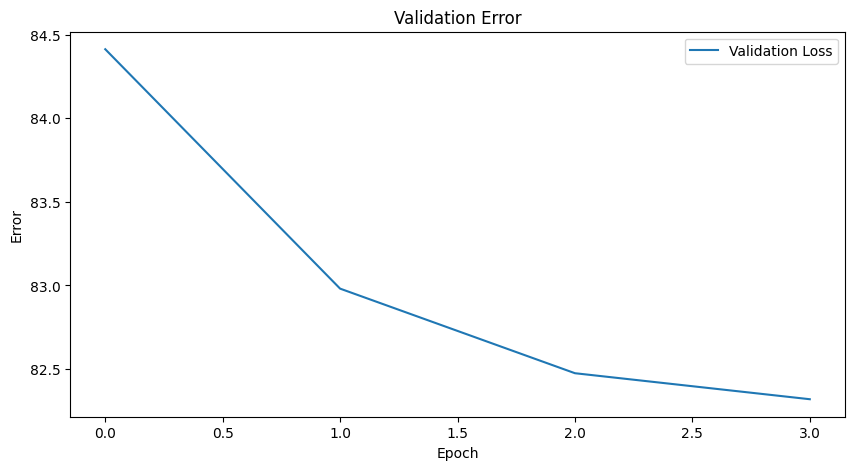

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 3 (With Pooling)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1635240
1074042


Epoch 1, Batch: 1000| Training Loss: 5.395469004154205
Epoch 1, Batch: 2000| Training Loss: 5.176014692306518
Epoch 1, Batch: 3000| Training Loss: 5.054431374867757
Epoch 1, Batch: 4000| Training Loss: 4.967140330851078
Epoch 1, Batch: 5000| Training Loss: 4.894964256715775
Epoch 1, Batch: 6000| Training Loss: 4.841230786164601
Epoch 1, Batch: 7000| Training Loss: 4.801570115123476
Epoch 1, Batch: 8000| Training Loss: 4.764032576084137
Epoch 1, Batch: 9000| Training Loss: 4.736011730114619
Epoch 1, Batch: 10000| Training Loss: 4.710235009169579
Epoch 1, Batch: 11000| Training Loss: 4.687637357690117
Epoch 1, Batch: 12000| Training Loss: 4.666666848977407
Epoch 1, Batch: 13000| Training Loss: 4.647181960674432
Epoch 1, Batch: 14000| Training Loss: 4.629871247087206
Epoch 1, Batch: 15000| Training Loss: 4.613379649241765
Epoch 1, Batch: 16000| Training Loss: 4.598858271881938
Epoch 1, Batch: 17000| Training Loss: 4.584812736595378
Epoch 1, Batch: 18000| Training Loss: 4.572868263747957
E

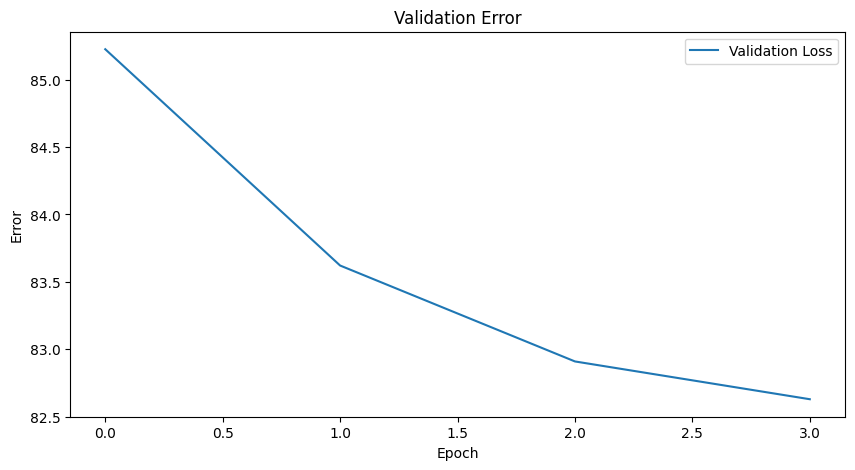

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 4 (Dense Architecture)

In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = DenseNetEncoder(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1635240
769450


Epoch 1, Batch: 1000| Training Loss: 5.495953320503235
Epoch 1, Batch: 2000| Training Loss: 5.323993716239929
Epoch 1, Batch: 3000| Training Loss: 5.214595885833105
Epoch 1, Batch: 4000| Training Loss: 5.121598199903965
Epoch 1, Batch: 5000| Training Loss: 5.035450867795944
Epoch 1, Batch: 6000| Training Loss: 4.96518195784092
Epoch 1, Batch: 7000| Training Loss: 4.907126547166279
Epoch 1, Batch: 8000| Training Loss: 4.851445156514645
Epoch 1, Batch: 9000| Training Loss: 4.806792579703861
Epoch 1, Batch: 10000| Training Loss: 4.765358306407928
Epoch 1, Batch: 11000| Training Loss: 4.726995722900737
Epoch 1, Batch: 12000| Training Loss: 4.691529249747594
Epoch 1, Batch: 13000| Training Loss: 4.658310576328865
Epoch 1, Batch: 14000| Training Loss: 4.628354511260986
Epoch 1, Batch: 15000| Training Loss: 4.599925049559276
Epoch 1, Batch: 16000| Training Loss: 4.5737392834723
Epoch 1, Batch: 17000| Training Loss: 4.548864794787239
Epoch 1, Batch: 18000| Training Loss: 4.5261280860768425
Epo

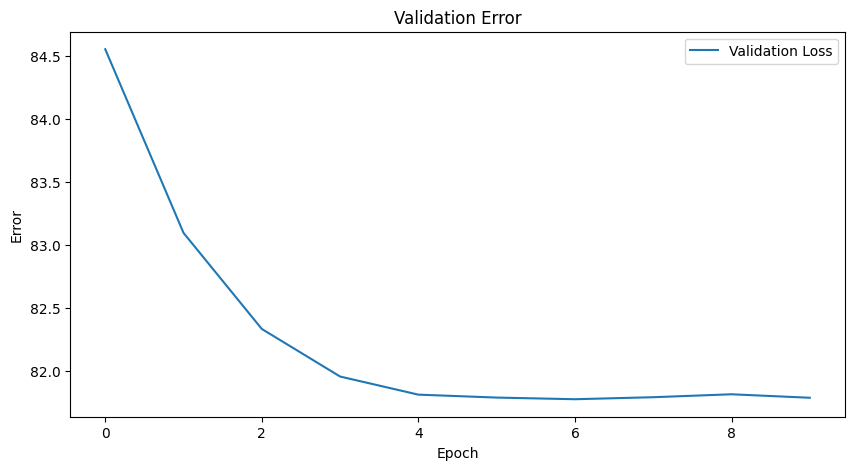

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

## Experiment 5 (12 channels)


In [ ]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
NUM_EPOCHS = 3
d_out = len(vocab.id_to_move.keys())
model = ChessCNN_no_pooling(d_out) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1634474
1283150


Epoch 1, Batch: 1000| Training Loss: 5.323950476408005
Epoch 1, Batch: 2000| Training Loss: 5.037779485702514
Epoch 1, Batch: 3000| Training Loss: 4.875874344348907
Epoch 1, Batch: 4000| Training Loss: 4.763434353649616
Epoch 1, Batch: 5000| Training Loss: 4.674505051565171
Epoch 1, Batch: 6000| Training Loss: 4.609323180556297
Epoch 1, Batch: 7000| Training Loss: 4.557679312433515
Epoch 1, Batch: 8000| Training Loss: 4.511355989933014
Epoch 1, Batch: 9000| Training Loss: 4.474164873255623
Epoch 1, Batch: 10000| Training Loss: 4.441874219655991
Epoch 1, Batch: 11000| Training Loss: 4.413282606493343
Epoch 1, Batch: 12000| Training Loss: 4.386133214692275
Epoch 1, Batch: 13000| Training Loss: 4.363250862726798
Epoch 1, Batch: 14000| Training Loss: 4.343148698840823
Epoch 1, Batch: 15000| Training Loss: 4.32341782617569
Epoch 1, Batch: 16000| Training Loss: 4.305715050026774
Epoch 1, Batch: 17000| Training Loss: 4.289202414821176
Epoch 1, Batch: 18000| Training Loss: 4.274470758014255
Ep

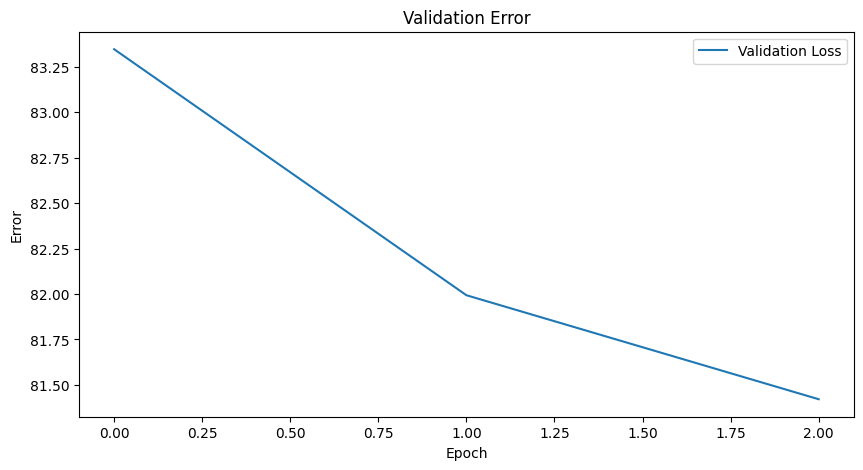

<Figure size 640x480 with 0 Axes>

In [ ]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_cnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

R . B Q . B . R
P P P . . K P P
. . N . . . . .
. . . N P . . .
. . b . . . . .
. . . . . . . .
p p p p . p p p
r n b q k . . r
Ke8
Ke6


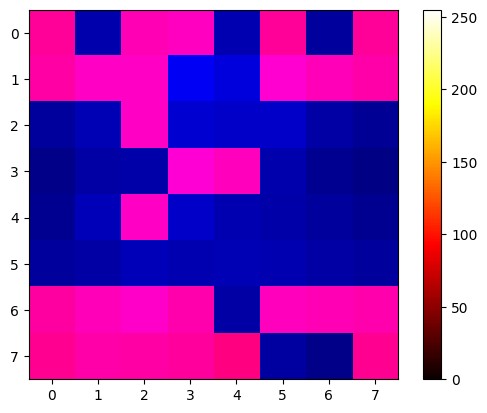


---------------------

R . B Q . B . R
P P P . . K P P
. . N . . . . .
. . . N P . . .
. . b . . . . .
. . . . . . . .
p p p p . p p p
r n b q k . . r
Qxd5
c6


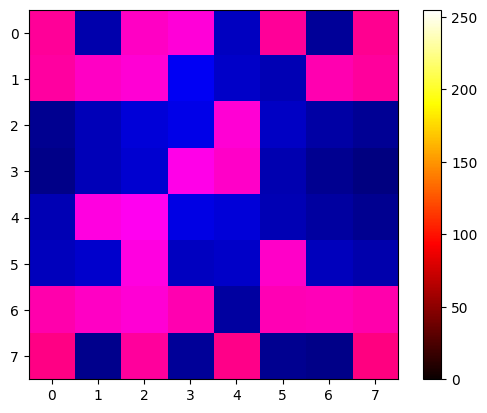


---------------------

R . B Q . B . R
P P P . . . P P
. . . . K . . .
. . . N P . . .
. N b . . . . .
. . n . . q . .
p p p p . p p p
r . b . k . . r
Qxd5
b5


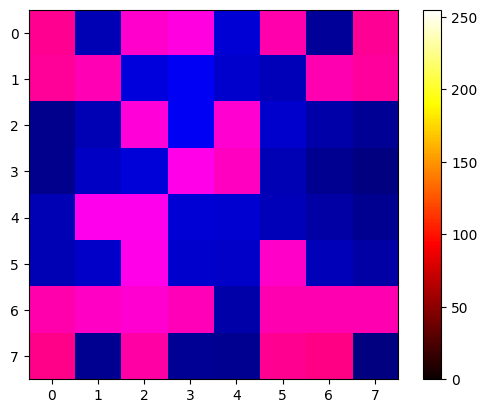


---------------------

R . B Q . B . R
P P . . . . P P
. . P . K . . .
. . . N P . . .
. N b . . . . .
. . n . . q . .
p p p p . p p p
r . b . . r k .
Nxc6
Qf6


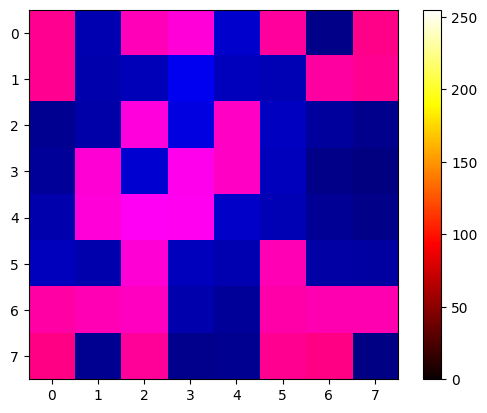


---------------------

R . B Q . B . R
P . . . . . P P
. . P . K . . .
. P . N P . . .
. N b p . . . .
. . n . . q . .
p p p . . p p p
r . b . . r k .
gxf6
gxf6


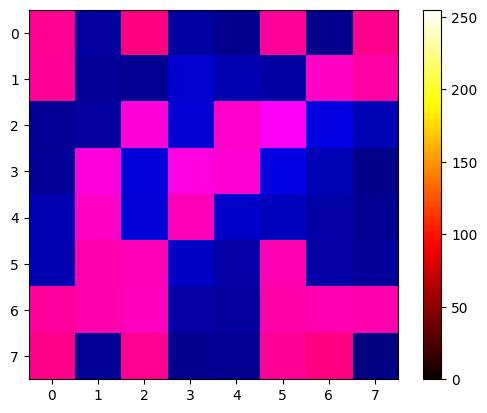


---------------------

R . B . . B . R
P . . . . . P P
. . P . K Q . .
. P . N P . . .
. N . p . . . .
. b n . . q . .
p p p . . p p p
r . b . . r k .
fxe5
Kd6


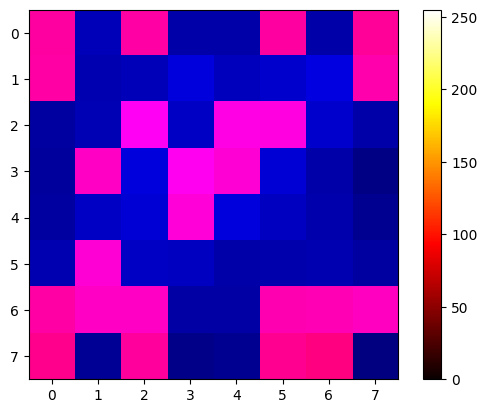


---------------------

R . B . . B . R
P . . . . . . P
. . P . K P . .
. P . N P . . .
. . . p . . . .
. b . . . . . .
p p p . . p p p
r . b . . r k .
e5
e5


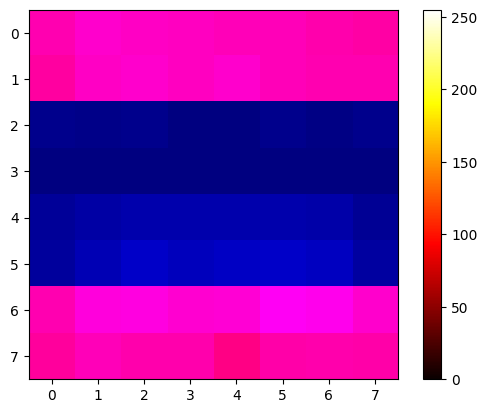


---------------------

R N B Q K B N R
P P P P P P P P
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
p p p p p p p p
r n b q k b n r
Nf6
Nf6


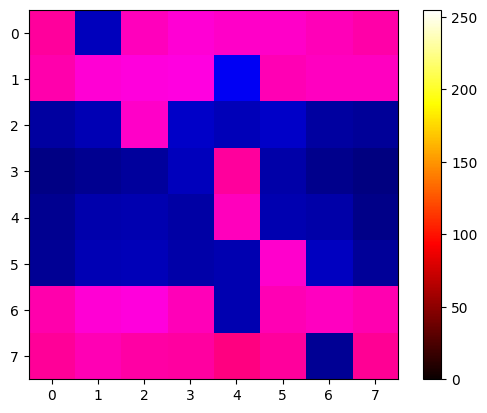


---------------------

R . B Q K B N R
P P P P . P P P
. . N . . . . .
. . . . P . . .
. . . . p . . .
. . . . . n . .
p p p p . p p p
r n b q k b . r
dxc6
dxc6


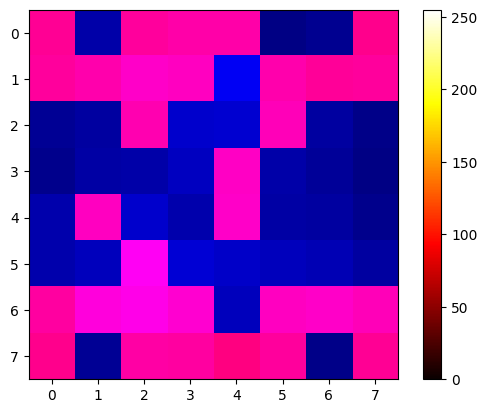


---------------------



In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Mapping from tensor indices to chess pieces
index_to_piece = {
    0: chess.PAWN, 1: chess.ROOK, 2: chess.KNIGHT,
    3: chess.BISHOP, 4: chess.QUEEN, 5: chess.KING,
    6: chess.PAWN, 7: chess.ROOK, 8: chess.KNIGHT,
    9: chess.BISHOP, 10: chess.QUEEN, 11: chess.KING
}

def convert_to_grayscale(image):
    # Assuming 'image' is a numpy array of shape (12, height, width)
    # Convert to grayscale by averaging the channels

    grayscale_image = image.mean(axis=0).mean(axis=0)

    return grayscale_image

def visualize_heatmap_on_chessboard(chessboard, heatmap):


    # Convert the 12-channel chessboard to a grayscale image for visualization
    grayscale_chessboard = convert_to_grayscale(chessboard)
    # Normalize the grayscale chessboard for visualization
    normalized_chessboard = grayscale_chessboard / grayscale_chessboard.max()

    zeros_channel = np.zeros_like(normalized_chessboard)
    
    three_channel_chessboard = np.stack((normalized_chessboard,zeros_channel,zeros_channel), axis=-1)

    # Ensure the heatmap is in the correct format and resize it to match the chessboard image
    heatmap_resized = np.resize(heatmap, (grayscale_chessboard.shape[0], grayscale_chessboard.shape[1]))
    heatmap_resized = np.stack((heatmap_resized,zeros_channel,zeros_channel), axis=-1)
    # Overlay the heatmap on the grayscale chessboard
    visualization = show_cam_on_image(three_channel_chessboard, heatmap_resized, use_rgb=True)

    # Display the visualization
    plt.imshow(visualization, cmap='hot')
    plt.colorbar()
    plt.show()

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

model.eval()
# Assuming ChessCNN_no_pooling is your model class
target_layers = [model.conv2]  # Use the last conv layer

# Initialize GradCAM with the model and target layers
cam = GradCAM(model=model, target_layers=target_layers)

# Assuming your data loader is named 'data_loader'
i = 0
for image, labels in train_loader:  # Iterate over your data
    # Specify the target; if None, the highest scoring category will be used
    # For simplicity, we're using None here
    if i > 20 and i < 30:
        _, predicted = torch.max(model(image).data, 1)
        print(vocab.get_move(predicted.item()))
        print(vocab.get_move(labels.item()))
        targets = None
        # Generate the CAM mask
        grayscale_cam = cam(input_tensor=image, targets=targets)
        # Visualize the first image in the batch
        visualize_heatmap_on_chessboard(image, grayscale_cam)

        # This is 
        board = chess.Board(None)  # Start with an empty board
        image = image.sum(axis=0)
        # Iterate over the tensor to place pieces on the board
        for channel, piece_type in index_to_piece.items():
            for row in range(8):
                for col in range(8):
                    if image[channel, row, col] > 0:  # Assuming nonzero value indicates presence of a piece
                        piece_color = chess.WHITE if channel < 6 else chess.BLACK
                        piece = chess.Piece(piece_type, piece_color)
                        square = chess.square(col, 7-row)  # chess.square() needs file index (0-7) and rank index (0-7)
                        board.set_piece_at(square, piece)

        # Now, 'board' contains the chessboard representation. You can print it as text:
        print(board)
        print("\n---------------------\n")
    elif i > 30:
        break
    i += 1


In [ ]:
torch.save(model.state_dict(), 'cnnmodel.pth')